In [29]:
import torch
from PIL import Image
import pandas as pd
from transformers import AutoProcessor, Blip2Processor, Blip2ForImageTextRetrieval,  Blip2ForConditionalGeneration, BitsAndBytesConfig

In [3]:
bnb_config = BitsAndBytesConfig(load_in_4bit=True)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [32]:
processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-flan-t5-xl"
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


In [33]:
csv = "powerpoint_data.csv"
df = pd.read_csv(csv)

pairs = []
for _, row in df.iterrows():
    pairs.append((row['fixed title'],row['fixed image dir'], row['fixed body']))
    pairs.append((row['waiting title'], row["waiting image dir"], row["waiting body"]))
    pairs.append((row['not fixed title'], row["not fixed image dir"], row["not fixed body"]))

titles  = [p[0] for p in pairs]
image_paths = [p[1] for p in pairs]
all_texts   = [p[2] for p in pairs]

In [34]:
batch_size = 16
generated_texts = []

for i in range(0, len(image_paths), batch_size):
    batch_paths = image_paths[i:i+batch_size]
    images = [Image.open(p) for p in batch_paths]
    
    inputs = processor(images=images, return_tensors="pt")
    inputs = {k: v.to(device, dtype=torch.float16) for k, v in inputs.items()}
    
    generated_ids = model.generate(**inputs, max_new_tokens=50)
    batch_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
    
    generated_texts.extend([t.strip() for t in batch_texts])


In [35]:
print(generated_texts[1])

a chair is sitting on top of a table in a plastic bag


In [36]:
model2 = Blip2ForImageTextRetrieval.from_pretrained("Salesforce/blip2-itm-vit-g", dtype=torch.float16)
processor2 = AutoProcessor.from_pretrained("Salesforce/blip2-itm-vit-g")

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


In [37]:
model2.to(device)

Blip2ForImageTextRetrieval(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
  )
  (embed

In [74]:
def compute_alignment(image_path, text):
    image = Image.open(image_path).convert("RGB")
    inputs = processor2(images=image, text=text, return_tensors="pt",padding=True).to(device, torch.float16)
    itm_out = model2(**inputs, use_image_text_matching_head=True)
    logits_per_image = torch.nn.functional.softmax(itm_out.logits_per_image, dim=1)
    probs = logits_per_image.softmax(dim=1)
    return probs

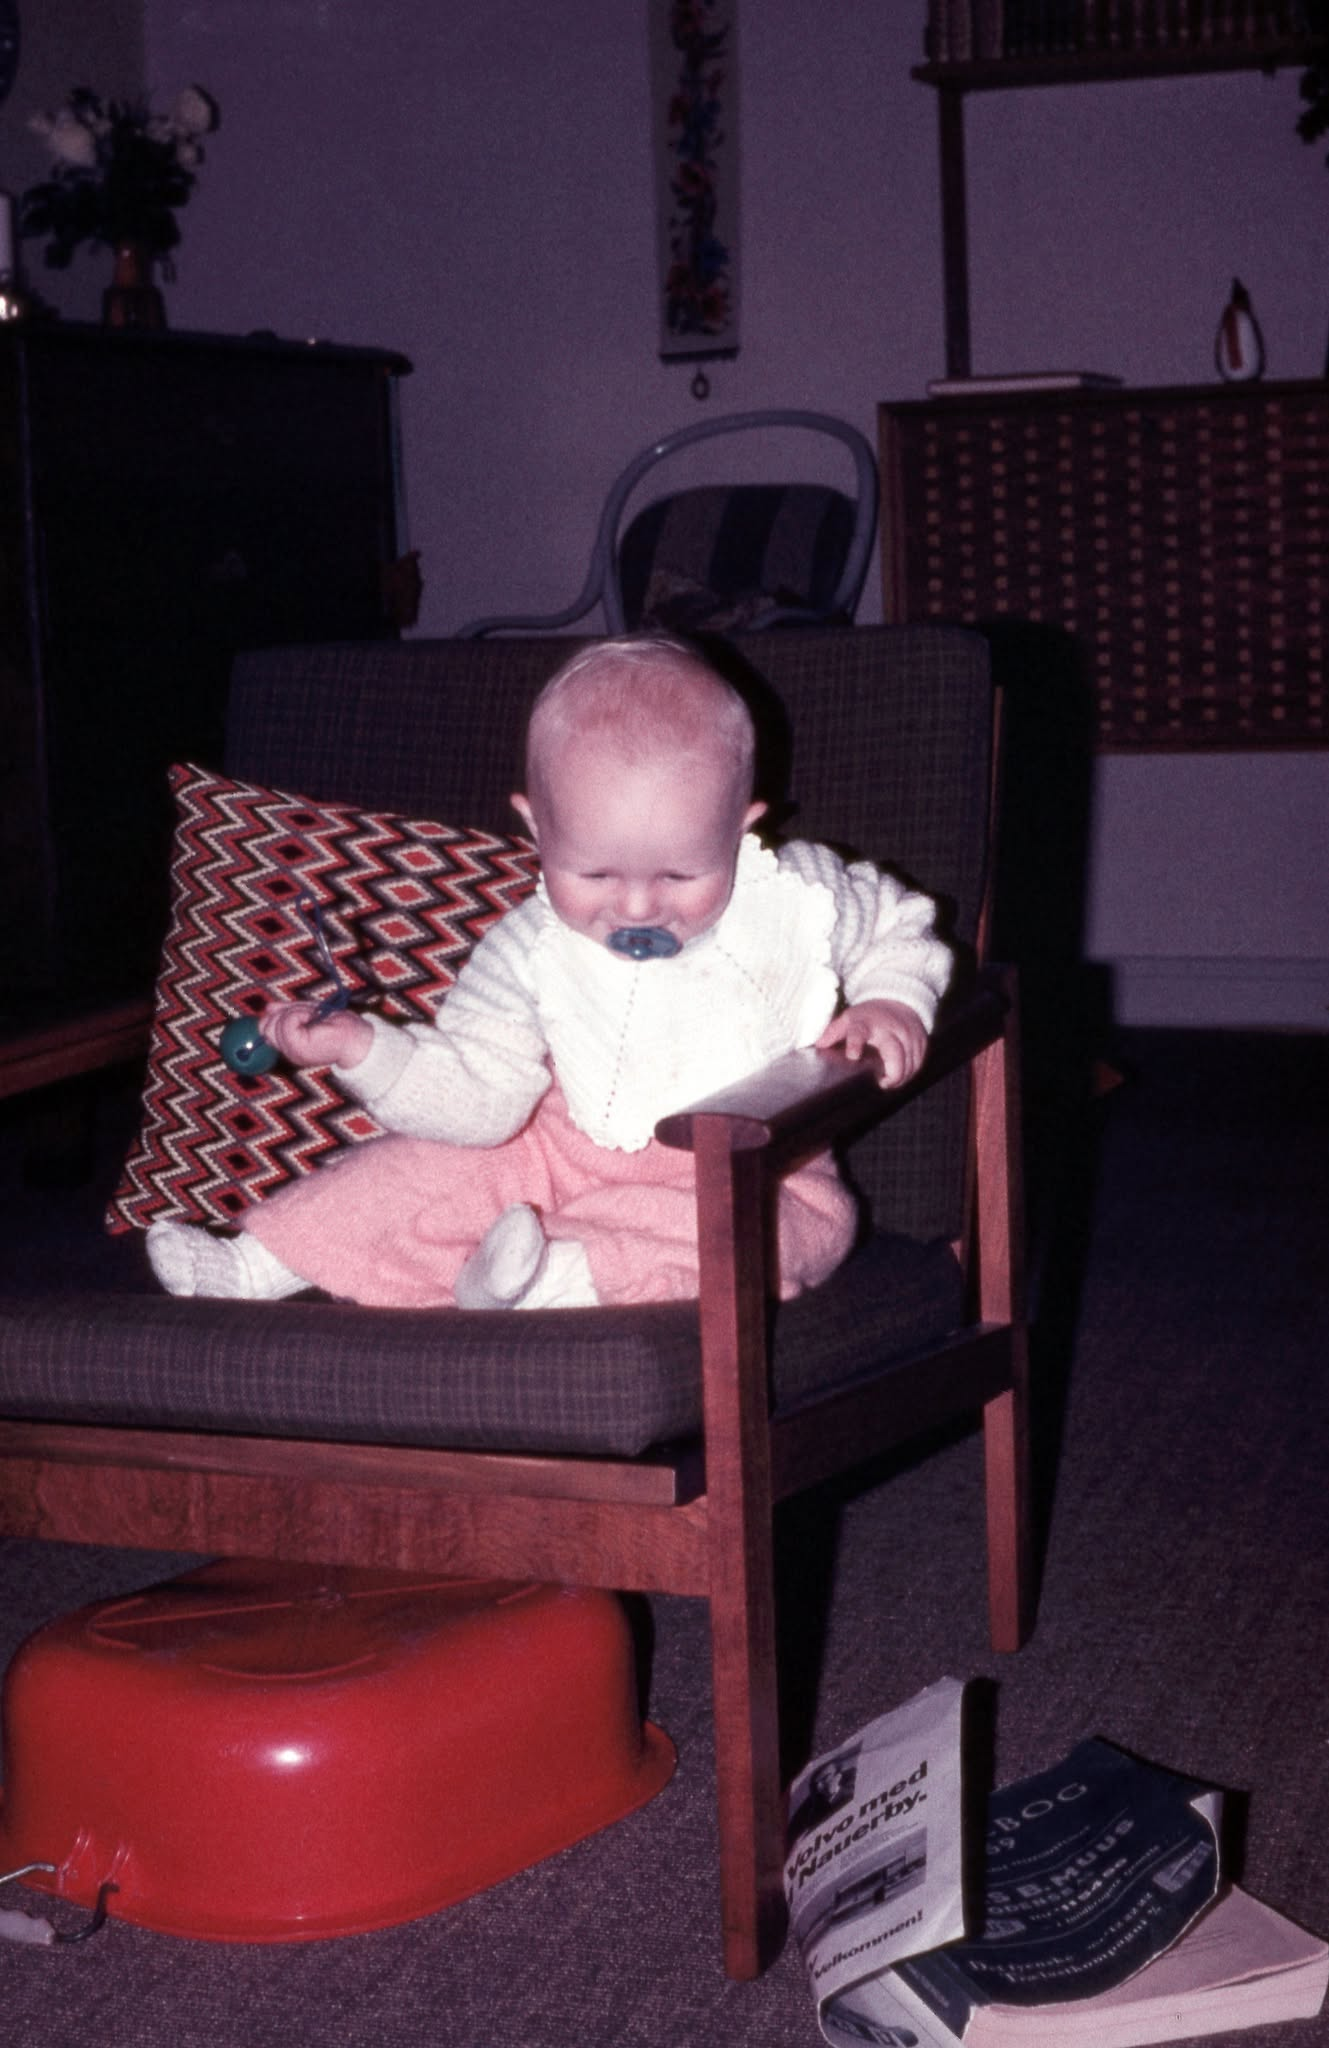

In [75]:
img = Image.open(image_paths[0])
img

In [76]:
prob = compute_alignment(image_paths[0], generated_texts[0])
print(f"{prob[0][0]:.1%} that image 0 is not '{generated_texts[0]}'")
print(f"{prob[0][1]:.1%} that image 0 is '{generated_texts[0]}'")

27.0% that image 0 is not 'a baby sitting in a chair with a pacifier'
73.0% that image 0 is 'a baby sitting in a chair with a pacifier'


In [78]:
prob1 = compute_alignment(image_paths[0], generated_texts[0])
prob2 = compute_alignment(image_paths[0], generated_texts[1])
prob3 = compute_alignment(image_paths[0], generated_texts[2])
print(f"{prob1[0][1]:.1%} that image 0 is '{generated_texts[0]}'")
print(f"{prob2[0][1]:.1%} that image 0 is '{generated_texts[1]}'")
print(f"{prob2[0][1]:.1%} that image 0 is '{generated_texts[2]}'")

73.0% that image 0 is 'a baby sitting in a chair with a pacifier'
26.9% that image 0 is 'a chair is sitting on top of a table in a plastic bag'
26.9% that image 0 is 'a blue glass cup with a blue lid'
